In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

c:\Users\sugay\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [3]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# ファイルの相対パスを指定
file_path = 'data_storage/Ising_data_L8_sss.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, label_data = loaded_data

In [5]:
# 逆温度データをインデックに格納する関数
def label_to_indices(data):
    # データを小さい順にソート
    sorted_data = sorted(data)
    
    # ソート後のデータと元のデータとの対応付けを行う辞書を作成
    data_mapping = {}
    current_label = 0

    for value in sorted_data:
        if value not in data_mapping:
            data_mapping[value] = current_label
            current_label += 1
    
    # 対応付けたラベルを取得
    labels = [data_mapping[value] for value in data]
    
    return labels


In [6]:
index_data = label_to_indices(label_data)
type(index_data)

list

In [7]:
# データのリストをNumPy配列に変換
spin_data_np = np.array(spin_data)
index_data_np = np.array(index_data)

# NumPy配列をPyTorchテンソルに変換
spin_data_tensor = torch.from_numpy(spin_data_np)
index_data_tensor = torch.from_numpy(index_data_np)

In [8]:
index_data_tensor

tensor([ 0,  0,  0,  ..., 24, 24, 24], dtype=torch.int32)

In [9]:
spin_data_tensor = spin_data_tensor.unsqueeze(1)
spin_data_tensor.shape

torch.Size([25000, 1, 8, 8])

In [10]:
print(spin_data_tensor[10000], index_data_tensor[10000])

tensor([[[-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.]]], dtype=torch.float64) tensor(10, dtype=torch.int32)


In [11]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, index_train, index_test = train_test_split(spin_data_tensor, index_data_tensor, test_size=0.5)

In [12]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
index_train = torch.tensor(index_train, dtype=torch.int64)  
index_test = torch.tensor(index_test, dtype=torch.int64)    

C:\Users\sugay\AppData\Local\Temp\ipykernel_19024\2025428175.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_19024\2025428175.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_19024\2025428175.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_train = torch.tensor(index_train, dtype=torch.int64)
C:\Users\sugay\AppData\Local\T

In [13]:
spin_train[1], index_train[1]

(tensor([[[ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1., -1.,  1., -1., -1., -1., -1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.,  1., -1., -1.,  1.],
          [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.]]]),
 tensor(3))

正解データはone-hot表現にする必要がある

In [14]:
# # テンソルを新しいテンソルに変換する関数を定義
# def to_one_hot(data, num_classes=25):
#     # one-hotベクトルの初期化
#     one_hot = torch.zeros(len(data), num_classes)
    
#     # 各要素を25次元のone-hotベクトルに変換
#     for i, val in enumerate(data):
#         index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
#         one_hot[i, index] = 1.0
    
#     return one_hot

# # label_train,temp_testをone-hotベクトルに変換
# one_hot_label_train = to_one_hot(label_train, num_classes=25)
# one_hot_temp_test = to_one_hot(temp_test, num_classes=25)

In [15]:
# データセットの作成
train_dataset = TensorDataset(spin_train, index_train)
test_dataset = TensorDataset(spin_test, index_test)

In [16]:
train_dataset[2]

(tensor([[[ 1., -1., -1., -1., -1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1., -1., -1., -1.,  1.],
          [ 1.,  1.,  1., -1., -1., -1.,  1.,  1.],
          [ 1., -1., -1., -1., -1., -1., -1.,  1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1.,  1., -1.,  1., -1., -1., -1.],
          [ 1., -1.,  1.,  1., -1., -1.,  1.,  1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1.]]]),
 tensor(2))

In [17]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [18]:
transformed_train_dataset[0]

(tensor([[[-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.]]]),
 tensor(21))

In [19]:
# DataLoaderの設定（バッチサイズ125）
train_loader = DataLoader(transformed_train_dataset, batch_size=125, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=125)

In [20]:
data_iter = iter(train_loader)
imgs, labels = next(data_iter)
labels

tensor([13, 20,  2, 22,  3, 20, 23, 15, 17,  2, 24, 20, 15, 12,  6,  8, 12, 18,
        20, 24, 22,  6,  5,  5, 10,  5, 11,  8,  1, 12,  2,  5, 16, 20, 23, 12,
        14,  2, 19,  4, 12, 10,  5,  3,  5, 22, 19,  3,  7, 13,  9, 14, 24,  3,
         5,  8, 20,  4,  0,  0, 18, 24,  5, 19,  6, 20, 22, 12, 21, 16, 12, 21,
        24, 14,  1,  9, 21,  2, 22,  1,  8, 18, 18,  7, 23, 17,  0,  0,  8, 24,
         9, 17, 14, 13, 10, 24,  6,  5,  6, 19, 12, 15, 10, 10,  1, 17,  0, 21,
         6, 24,  7, 15, 20, 14, 21, 18, 23,  2, 24, 21, 11, 20,  8, 15, 23])

In [21]:
imgs.size(), labels.size()

(torch.Size([125, 1, 8, 8]), torch.Size([125]))

In [22]:
inputs, targets = next(iter(train_loader))
inputs.shape, targets.shape

(torch.Size([125, 1, 8, 8]), torch.Size([125]))

In [23]:
for i in range(10):
    print(inputs[i])

tensor([[[-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.]]])
tensor([[[-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1.]]])
tensor([[[-1.,  1.,  1.,  1.,  1.,  1., -1.,  1.],
         [ 1.,  1.,  1.,  1., -1., -1., -1.,  1.],
         [ 1.,  1.,  1.,  1., -1.,  1., -1.,  1.],
         [-1.,  1.,  1.,  1

In [24]:
for i in range(10):
    print(targets[i])

tensor(18)
tensor(24)
tensor(2)
tensor(1)
tensor(8)
tensor(21)
tensor(8)
tensor(9)
tensor(10)
tensor(1)


モデルを定義

In [25]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_channels, out_channels):
        super().__init__()
        # 畳み込みの部分
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),  # 反射パディング
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=int(((input_size)**0.5)/4), bias=True),
            nn.ReLU(inplace=True),
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(out_channels*4*4, output_size, bias=True),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

モデルのインスタンス化

In [26]:
input_size = 8*8
output_size = 25
in_channels = 1
out_channels = 5  
model = CNN(input_size, output_size, in_channels, out_channels)
model.to(device)
# モデルの概要表示
print(model)

CNN(
  (conv): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 5, kernel_size=(3, 3), stride=(2, 2))
    (2): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=25, bias=True)
    (1): Softmax(dim=1)
  )
)


損失関数と最適化アルゴリズムの設定

In [27]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=5e-5)     # Adam,L2正則化{, weight_decay=5e-4}

学習の実行

In [28]:
num_epochs = 500
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        # targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        # test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # 正解数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 3.2068037748336793, acc: 0.06552000343799591, test loss: 3.1970942735672, test acc: 0.07648002356290817
epoch: 1, loss: 3.191224129199982, acc: 0.0814400166273117, test loss: 3.1893432044982912, test acc: 0.08048000931739807
epoch: 2, loss: 3.184247627258301, acc: 0.0917600467801094, test loss: 3.18547372341156, test acc: 0.08591999113559723
epoch: 3, loss: 3.179792037010193, acc: 0.09296000748872757, test loss: 3.1835597205162047, test acc: 0.08007999509572983
epoch: 4, loss: 3.1768245673179627, acc: 0.09600001573562622, test loss: 3.1811252570152284, test acc: 0.07912001758813858
epoch: 5, loss: 3.173932662010193, acc: 0.10200002044439316, test loss: 3.1783900570869448, test acc: 0.0936800092458725
epoch: 6, loss: 3.1717061400413513, acc: 0.11128002405166626, test loss: 3.176759021282196, test acc: 0.0987199991941452
epoch: 7, loss: 3.1693492889404298, acc: 0.11000002920627594, test loss: 3.174951341152191, test acc: 0.10952000319957733
epoch: 8, loss: 3.1667983150482

KeyboardInterrupt: 

損失関数と正解率のグラフの作成

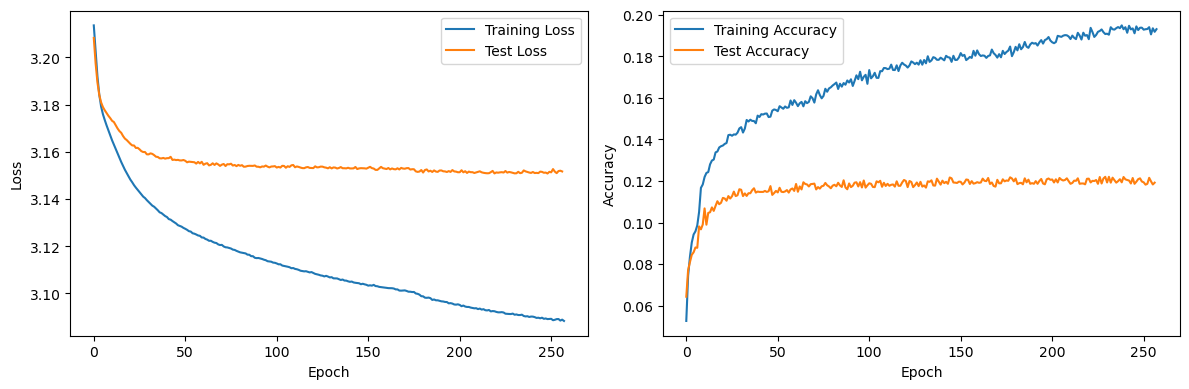

In [ ]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [ ]:
print(test_pred[:100])

tensor([ 4,  9, 23, 23,  2, 10,  8, 23,  4,  5,  4, 10, 23, 10, 23,  1,  9, 23,
        23,  8, 23,  4, 23,  1, 23, 23,  0, 23, 23,  1,  8, 10,  8, 23,  3,  2,
         4, 23, 23, 23,  5, 23,  3,  7,  8, 23, 10,  7, 23,  0, 23, 23,  0,  2,
         1,  9,  4,  4,  6, 23,  6,  5, 23,  9, 23, 23,  1, 23, 19, 23, 23,  3,
        23,  7, 10, 23,  2,  1, 23,  9,  7, 23, 23,  0, 23, 23,  8, 23, 10, 23])


In [ ]:
print(test_targets[:100])

tensor([ 3,  9, 22, 13,  0, 13,  8, 23,  6,  4,  3, 13, 20, 11, 23,  2,  8, 14,
        20,  7, 18,  5, 16,  0, 13, 23,  0, 15, 23,  1, 10, 14,  9, 21,  0,  1,
         0, 16, 19, 21,  7, 22,  4, 20,  9, 13,  9,  4, 23,  0,  9, 16,  0,  1,
         0, 10,  8,  6,  8, 16,  6,  6, 17,  9, 20, 12,  3, 12, 15, 22, 21,  5,
        13, 18, 15, 24,  3,  0, 14,  7,  5, 16, 14,  1, 13, 19,  9, 10, 10, 20])


In [ ]:
test_output.shape

torch.Size([90, 25])

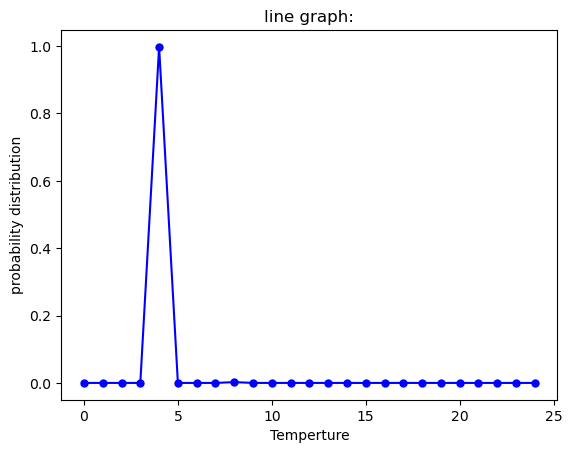

tensor(3)


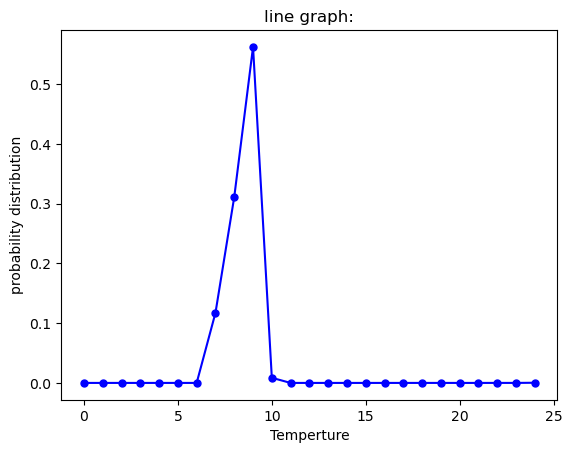

tensor(9)


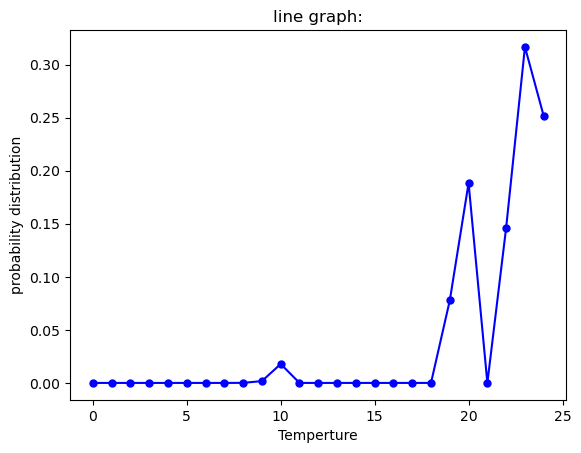

tensor(22)


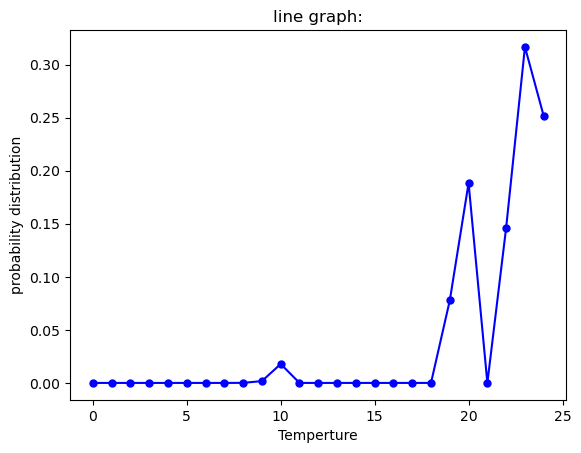

tensor(13)


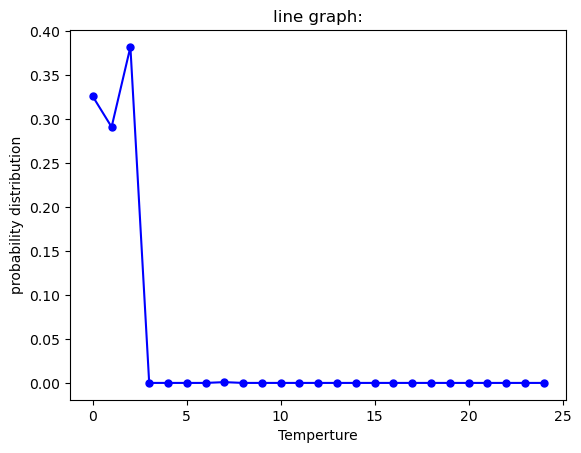

tensor(0)


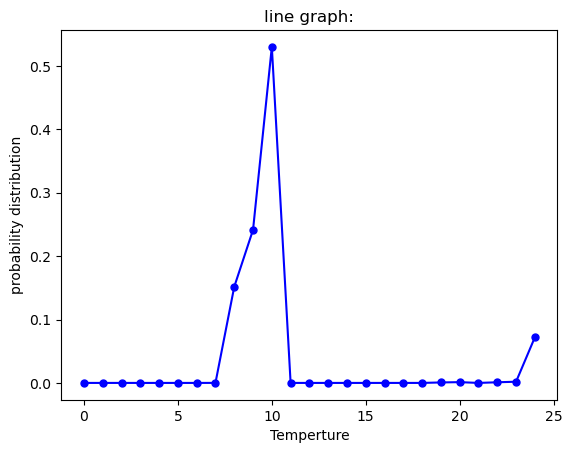

tensor(13)


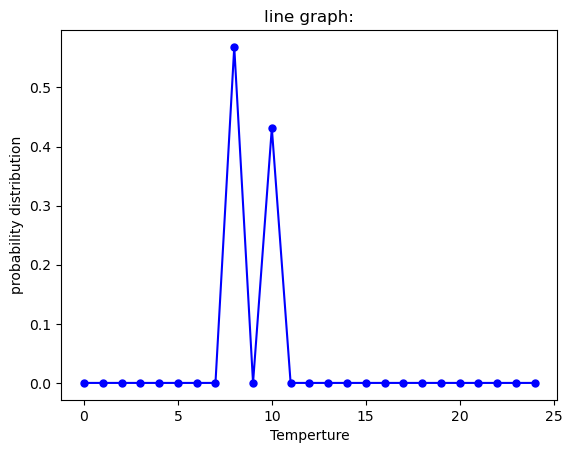

tensor(8)


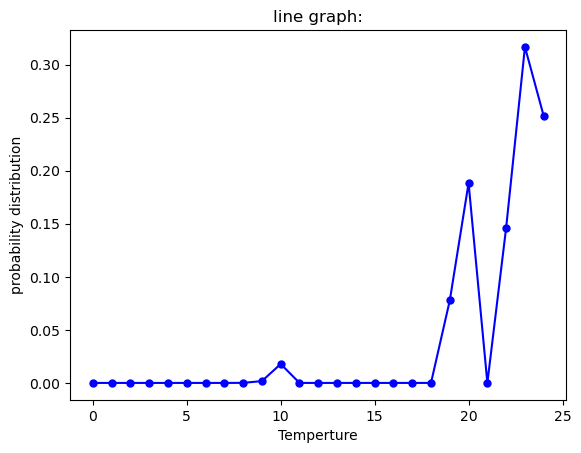

tensor(23)


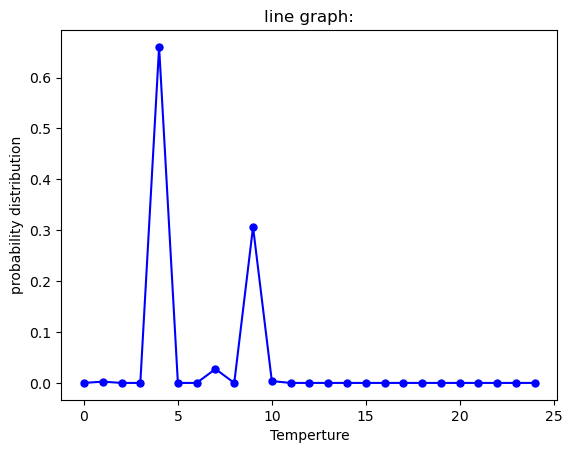

tensor(6)


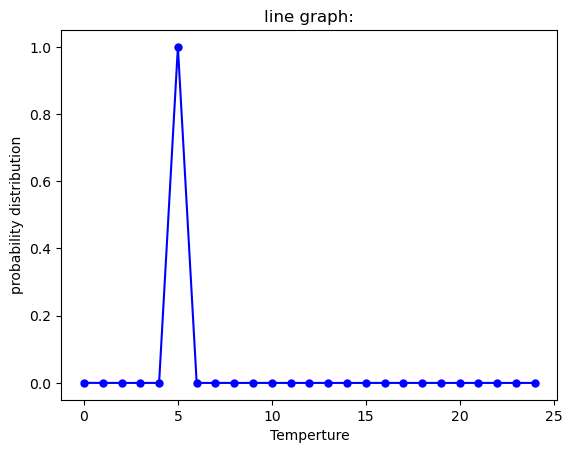

tensor(4)


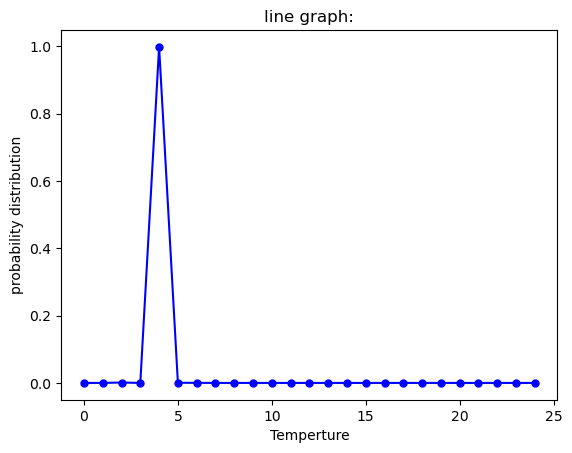

tensor(3)


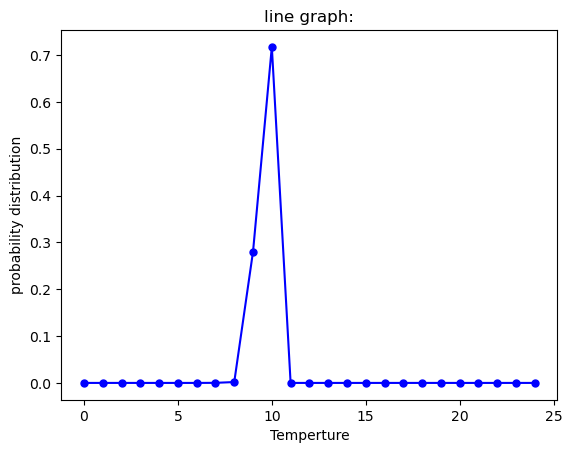

tensor(13)


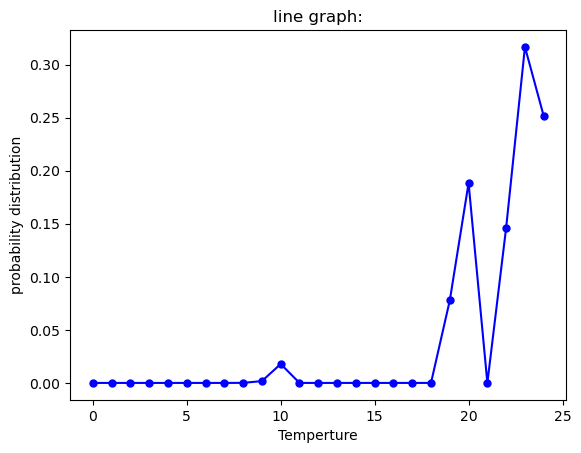

tensor(20)


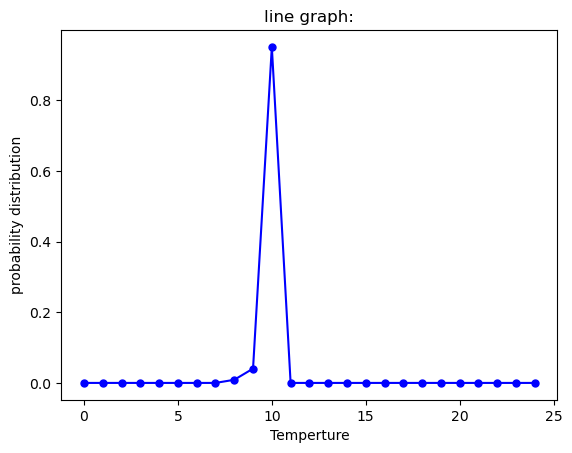

tensor(11)


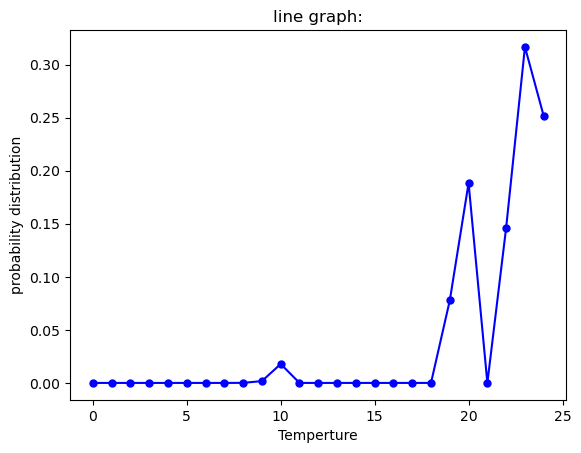

tensor(23)


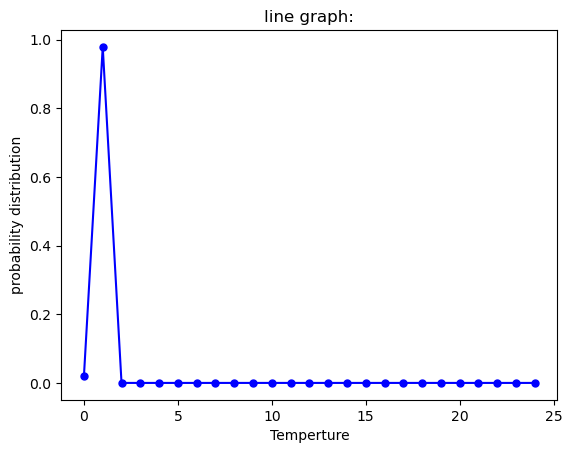

tensor(2)


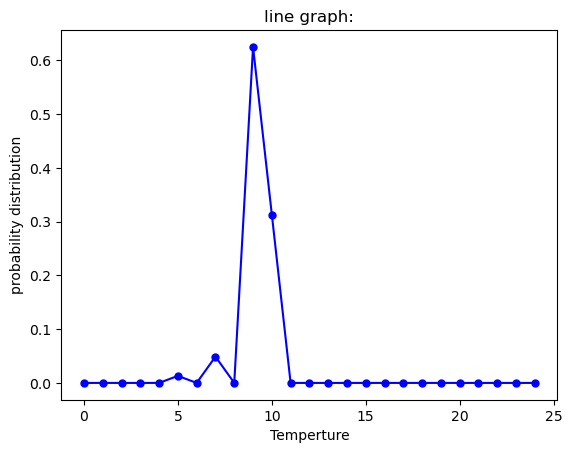

tensor(8)


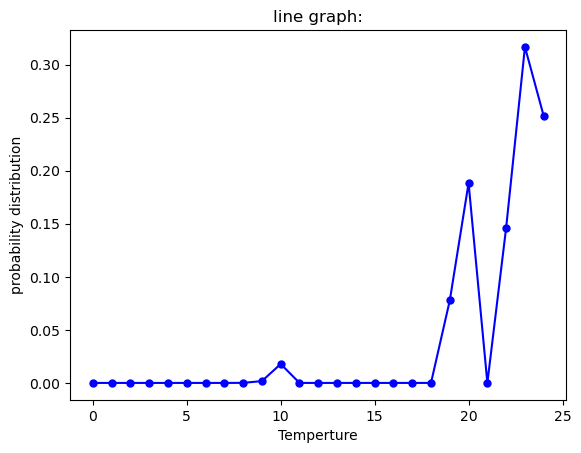

tensor(14)


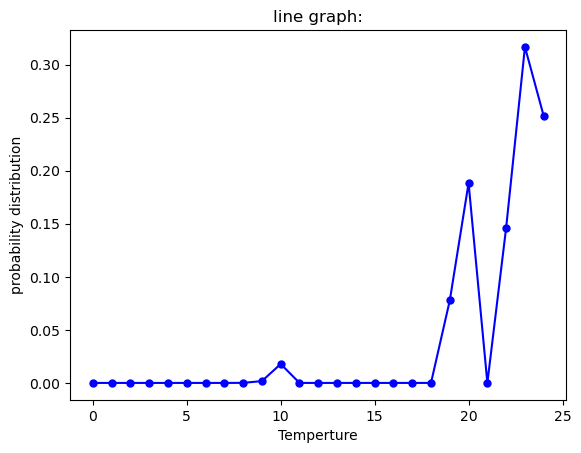

tensor(20)


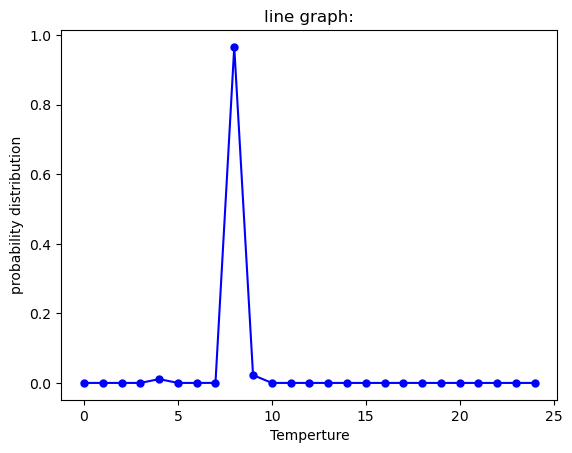

tensor(7)


In [ ]:
# データのx軸値
x = [i for i in range(25)]

for n in range(20):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('Temperture')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n])


モデルの保存

In [ ]:
torch.save(model.state_dict(), 'data_storage/CNN_L8_sss.pth')